In [70]:
import pandas as pd
# Leer el CSV
train = pd.read_csv("train.csv")

#### A simple vista en la base de datos observamos datos extraños como símbolos de exclamación, muchos '-9' y muchos valores ilógicos como 0 en colesterol (algo que no es posible)

In [71]:
missing_vals = {-9.0, -9, '-9.0', '-9'}
mask_neg = train.isin(missing_vals).any(axis=1)
mask_q = (train == '?').any(axis=1)
mask_chol_0 = (train['chol'] == 0) | (train['chol'] == '0')

num_neg = mask_neg.sum()
print("Filas con al menos un -9:", num_neg)
num_q = mask_q.sum()
print("Filas con al menos un '?':", num_q)
num_chol0 = mask_chol_0.sum()
print("Filas donde chol = 0:", num_chol0)

Filas con al menos un -9: 232
Filas con al menos un '?': 254
Filas donde chol = 0: 135


### Ahora queremos ver si los errores aparecen simultaneamente o son separados.

In [72]:
both = train[mask_neg & mask_q]
print("Filas con -9.0 y '?' al mismo tiempo:", len(both))

Filas con -9.0 y '?' al mismo tiempo: 0


In [73]:
rows_q_with_chol0 = train[mask_q & mask_chol_0]
rows_neg_with_chol0 = train[mask_neg & mask_chol_0]


print("Número de filas con -9 y chol=0:", len(rows_neg_with_chol0))
print("Número de filas con '?' y chol=0:", len(rows_q_with_chol0))

Número de filas con -9 y chol=0: 0
Número de filas con '?' y chol=0: 135


### Ya había un patrón claro, el -9 y el resto de errores estaban diferenciados. Por otra parte nos dimos cuenta de que habían columnas con los mismos valores pero en diferente formato, por ejemplo en slope existía el dato 2 diferenciado del dato 2.0 (concretamente pasa con estas columnas: trestbps, chol, fbs, thalach, exang, oldpeak, slope y thal), y que ademas a simple vista parecia que dependiendo del formato había un tipo de error u otro.

In [74]:
cols = ['trestbps', 'chol', 'fbs', 'thalach', 'exang', 'slope', 'thal']
train[cols].head(10)

,trestbps,chol,fbs,thalach,exang,slope,thal
0,125.0,213.0,0.0,125.0,1.0,1.0,3.0
1,120.0,237.0,0.0,150.0,1.0,-9.0,7.0
2,140,0,?,149,0,1,?
3,140.0,-9.0,0.0,140.0,0.0,-9.0,-9.0
4,140.0,217.0,0.0,111.0,1.0,3.0,7.0
5,120.0,169.0,0.0,144.0,1.0,3.0,6.0
6,122.0,192.0,0.0,174.0,0.0,1.0,3.0
7,135,297,0,130,1,2,?
8,135,0,0,120,1,1,7
9,140.0,231.0,0.0,140.0,1.0,2.0,-9.0


### con estas pocas muestras se puede ver mas o menbos que donde hay ? no hay floats, mientras donde hay -9s si que los hay, aun asi lo analizamos mas a fondo: llamaremos grupo A a las muestras donde hayan enteros en las columnas mencionadas, llamaremos grupo B a las que son floats o terminan en .0

In [75]:
cols = ['trestbps', 'chol', 'fbs', 'thalach', 'exang', 'slope', 'thal']
mask_A = train[cols].applymap(
    lambda x: (
        isinstance(x, str) and 
        ('.' not in x or x.startswith('.'))
    )
).all(axis=1)
mask_B = train[cols].applymap(
    lambda x: (
        isinstance(x, str) and 
        '.' in x and 
        not x.startswith('.')
    )
).any(axis=1)


num_A = mask_A.sum()
num_B = mask_B.sum()

print("Grupo A (enteros):", num_A)
print("Grupo B (decimales normales):", num_B)

Grupo A (enteros): 252
Grupo B (decimales normales): 480


### Veamos cuantos -9s y cuantos ? existen en grupo A (valores sin .0)

In [76]:
A_neg = (mask_A & mask_neg).sum()
A_q   = (mask_A & mask_q).sum()

print("Grupo A con -9:", A_neg)
print("Grupo A con '?':", A_q)

Grupo A con -9: 0
Grupo A con '?': 251


### Ya sabemos que los ? indiscutiblemente forman parte del grupo A, hagamos lo mismo con grupo B (acabados en .0 0 con decimales normales)

In [77]:
B_neg = (mask_B & mask_neg).sum()
B_q   = (mask_B & mask_q).sum()

print("Grupo B con -9:", B_neg)
print("Grupo B con '?':", B_q)

Grupo B con -9: 232
Grupo B con '?': 3


### A pesar de esos 3 datos, también hay un patron bastante claro, veamos ahora para cada grupo el porcentaje de errores que tiene

In [78]:
percent_q_A = (mask_A & mask_q).sum() / mask_A.sum() * 100
print(f"Porcentaje de filas con '?' en Grupo A: {percent_q_A:.2f}%")
percent_neg_B = (mask_B & mask_neg).sum() / mask_B.sum() * 100
print(f"Porcentaje de filas con -9 en Grupo B: {percent_neg_B:.2f}%")


Porcentaje de filas con '?' en Grupo A: 99.60%
Porcentaje de filas con -9 en Grupo B: 48.33%


### En grupo A (enteros con errores como '?' o chol=0), practicamente todas las filas tienen ?, mientars que en grupo B (los errores unicamente son los -9) solo hay errores en la mitad de las muestras, veamos si difieren significativamente estas dos mitades de las muestras con respecto a la variable a predecir para tratarlas o no distinto

In [79]:
# Filas en Grupo B que tienen -9
rows_B_neg = train.loc[mask_B & mask_neg, 'label'].astype(float)

# Media del label
mean_B_neg = rows_B_neg.mean()
print("Media del label en Grupo B con -9:", mean_B_neg)

# Filas en Grupo B que NO tienen -9
rows_B_no_neg = train.loc[mask_B & (~mask_neg), 'label'].astype(float)

# Media del label
mean_B_no_neg = rows_B_no_neg.mean()
print("Media del label en Grupo B sin -9:", mean_B_no_neg)



Media del label en Grupo B con -9: 0.7931034482758621
Media del label en Grupo B sin -9: 0.9193548387096774


### No parecen haber muchas diferencias entre las muestras con -9 y las muestras sin en el grupo B, ahora veamos si grupo A y grupo B, que en la forma de sus datos muestan bastates diferncias, tienen diferencias en el label.

In [80]:
# Media del label para Grupo A
mean_A = train.loc[mask_A, 'label'].astype(float).mean()

# Media del label para Grupo B
mean_B = train.loc[mask_B, 'label'].astype(float).mean()

print("Media del label en Grupo A:", mean_A)
print("Media del label en Grupo B:", mean_B)

Media del label en Grupo A: 1.6547619047619047
Media del label en Grupo B: 0.8583333333333333


### Parece que sí que hay diferencias, lo tendremos en cuenta, sobretodo a la hora de rellenar datos erroneos.

### Nos llama la atención que en las columnas ca y thal esta lleno de ? y de -9, veamos por grupos como se comportan.

In [81]:
# Filas del Grupo B
grupo_A = train[mask_A]

# Porcentaje de '?' en columna 'ca'
percent_q_ca = (grupo_A['ca'] == '?').sum() / len(grupo_A) * 100

# Porcentaje de '?' en columna 'thal'
percent_q_thal = (grupo_A['thal'] == '?').sum() / len(grupo_A) * 100

print(f"Porcentaje de '?' en 'ca' dentro del Grupo A: {percent_q_ca:.2f}%")
print(f"Porcentaje de '?' en 'thal' dentro del Grupo A: {percent_q_thal:.2f}%")


Porcentaje de '?' en 'ca' dentro del Grupo A: 98.02%
Porcentaje de '?' en 'thal' dentro del Grupo A: 66.67%


### En todo un grupo practicamemte no hay información en ca, esto ya puede darnos una pista de que ca podria ser una variable irrelevante

In [82]:
# Filas del Grupo B
grupo_B = train[mask_B]

# Porcentaje de -9 en columna 'ca'
percent_neg_ca = grupo_B['ca'].isin(['-9', '-9.0', -9, -9.0]).sum() / len(grupo_B) * 100

# Porcentaje de -9 en columna 'thal'
percent_neg_thal = grupo_B['thal'].isin(['-9', '-9.0', -9, -9.0]).sum() / len(grupo_B) * 100

print(f"Porcentaje de -9 en 'ca' dentro del Grupo B: {percent_neg_ca:.2f}%")
print(f"Porcentaje de -9 en 'thal' dentro del Grupo B: {percent_neg_thal:.2f}%")


Porcentaje de -9 en 'ca' dentro del Grupo B: 47.92%
Porcentaje de -9 en 'thal' dentro del Grupo B: 43.75%


### Tambien hay muchos errores pero al  menos mas de la mitad hay, como solo tenemos info de ca en grupo B, veamos si ca y thal en este grupo estan altamente correlacionadas.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Tabla de contingencia
tabla = pd.crosstab(grupo_B['ca'], grupo_B['thal'])
# Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla)
# Cramer's V
n = tabla.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(tabla.shape)-1)))
print("Cramer's V:", cramers_v)



Cramer's V: 0.4720845563652332


### la correlación es muy alta, por lo tanto ya que ca no da nada de info en grupo A, es muy probable que deba eliminarse ya que solo aporta ruido.

### Como hacemos para rellenar los errores en cada grupo?

### Empecemos a analizar las columnas slope y thal que son las más problemáticas

In [84]:
# Aseguramos que slope se trate como string para no perder categorías raras
slope_str = train['slope'].astype(str)

# Agrupar y obtener media del label + conteo
resumen_slope = train.groupby(slope_str)['label'].agg(['mean', 'count'])

print(resumen_slope)

           mean  count
slope                 
-9.0   0.328947    152
1      1.648649     37
1.0    0.347107    121
2      1.766667     90
2.0    1.550802    187
3      2.100000     30
3.0    1.500000     20
?      1.410526     95


### Podemos ver que los -9 en slope actúan prácticamente igual que su valor más bajo del grupo B del que pertenecen (1.0), tanto en número de muestras como en media, a diferencia de los 1 (sin .0) que forman parte como recordamos del grupo A. Esto nos deja claro que los -9 no son errores por azar como quizás sí que son los ? (ya que tienen una media que no muestra ningún patrón visible). 

In [85]:
# Aseguramos que thal se trate como string para no perder categorías raras
thal_str = train['thal'].astype(str)

# Agrupar y obtener media del label + conteo
resumen_thal = train.groupby(thal_str)['label'].agg(['mean', 'count'])

print(resumen_thal)


          mean  count
thal                 
-9.0  0.790476    210
3     1.750000     20
3.0   0.306569    137
6     2.071429     14
6.0   1.363636     22
7     1.800000     50
7.0   1.581818    110
?     1.556213    169


### Aquí no está tan claro, es evidente que los -9 tienen una media inferior, pero no es tan próxima a la media que tiene el numero más bajo de thal (3.0). Tendrá que ver con que cuando hay -9 en slope y tambien en thal significa una cosa, y cuando hay solo un -9 en thal sigmifique otra? Veamos.

In [87]:
# Convertir a string para comparar correctamente
thal_str = train['thal'].astype(str)
slope_str = train['slope'].astype(str)

# Máscaras
mask_thal_neg = thal_str.isin(['-9', '-9.0'])
mask_slope_neg = slope_str.isin(['-9', '-9.0'])

# 1. Media del label cuando thal es -9
media_1 = train.loc[mask_thal_neg, 'label'].mean()

# 2. Media del label cuando thal es -9 Y slope es -9
media_2 = train.loc[mask_thal_neg & mask_slope_neg, 'label'].mean()

# 3. Media del label cuando thal es -9 PERO slope NO es -9
media_3 = train.loc[mask_thal_neg & (~mask_slope_neg), 'label'].mean()

print("1) Media del label con thal = -9:", media_1)
print("2) Media del label con thal = -9 y slope = -9:", media_2)
print("3) Media del label con thal = -9 y slope != -9:", media_3)


1) Media del label con thal = -9: 0.7904761904761904
2) Media del label con thal = -9 y slope = -9: 0.30656934306569344
3) Media del label con thal = -9 y slope != -9: 1.6986301369863013


### BINGO. Cuando slope y thal son -9 juntos la media de esto -9 de thal es prácticamente igual a el numero mas bajo de thal (en grupo B). Esto nos podría decir que los -9 (con -9 en slope) deben rellenarse como el numero mas sano (bajo) de la columna, mientras que los -9 que no aparecen al mismo tiempo en slope, como un numero más elevado (ya que la media en este caso es de 1,7, mucho mas elevada)

### Con los interrogantes nos hay patrón visible, sería mejor rellear con mediana o alguna técnica similar.

### También hay -9 en columnas como chol y alguna más pero muy pocos, no creo que se pueda encontrar un patrón tan claro, como son tan pocos los rellenaremos con mediana también.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
def asignar_hospital(fila):
    fila_str = fila.astype(str).str.strip()

    # Hospital A: cualquier -9
    if ('-9' in fila_str.values) or ('-9.0' in fila_str.values):
        return "Hospital A"

    # Hospital B: tiene ?, o chol = 0, o oldpeak = 0
    elif ('?' in fila_str.values) or (fila.get('chol', None) == 0) or (fila.get('oldpeak', None) in ["0", 0]):
        return "Hospital B"

    else:
        return "Hospital A"


# =====================================================================
# 2️⃣ APLICAR HOSPITAL A TRAIN Y TEST
# =====================================================================
train['hospital'] = train.apply(asignar_hospital, axis=1)

# Pasar a 0/1
train['hospital'] = train['hospital'].str.lower().str.strip().map(lambda x: 1 if 'b' in x else 0)


# =====================================================================
# 3️⃣ ELIMINAR COLUMNA 'ca' SI EXISTE
# =====================================================================
for df in [train]:
    if 'ca' in df.columns:
        df.drop(columns=['ca'], inplace=True)



# =====================================================================
# 4️⃣ ARREGLAR SLOPE Y THAL (-9 SEGÚN REGLAS)
# =====================================================================
for df in [train]:
    df['slope'] = pd.to_numeric(df['slope'], errors='coerce')
    df['thal']  = pd.to_numeric(df['thal'], errors='coerce')

# Regla 1: slope == -9 → slope = 1
train.loc[train['slope'] == -9, 'slope'] = 1

# Regla 2: slope = 1 y thal = -9 → thal = 3
mask_train = (train['slope'] == 1) & (train['thal'] == -9)

train.loc[mask_train, 'thal'] = 3

# Regla 3: thal = -9 y slope != 1 → thal = 7
mask_train2 = (train['thal'] == -9) & (train['slope'] != 1)

train.loc[mask_train2, 'thal'] = 7


# =====================================================================
# 5️⃣ CONVERTIR -9, ?, CHOL=0, OLDPEAK=0 → NaN
# =====================================================================
for df in [train]:

    # Convertir texto a numérico cuando posible
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')

    # Reemplazar -9, '?'
    df.replace('-9.0', np.nan, inplace=True)
    df.replace('?', np.nan, inplace=True)

    # CHOL = 0 → NaN
    if 'chol' in df.columns:
        df.loc[df['chol'] == '0', 'chol'] = np.nan

    # OLDPEAK = 0 o "0" → NaN
    if 'chol' in df.columns:
        df.loc[df['chol'] == '0', 'chol'] = np.nan

# =====================================================================
# 6️⃣ RELLENAR NAN CON MEDIANA DE TRAIN
# =====================================================================
medianas = train.median(numeric_only=True)

train.fillna(medianas, inplace=True)



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,thal,label,hospital
0,51.0,1.0,1.0,125.0,213.0,0.0,2.0,125.0,1.0,1.4,1.0,3.0,0,0
1,54.0,1.0,3.0,120.0,237.0,0.0,0.0,150.0,1.0,1.5,1.0,7.0,2,0
2,63.0,1.0,4.0,140,NaN,NaN,2.0,149,0,2,1.0,3.0,2,1
3,52.0,0.0,2.0,140.0,NaN,0.0,0.0,140.0,0.0,0.0,1.0,3.0,0,0
4,55.0,1.0,4.0,140.0,217.0,0.0,0.0,111.0,1.0,5.6,3.0,7.0,3,0
5,44.0,1.0,4.0,120.0,169.0,0.0,0.0,144.0,1.0,2.8,3.0,6.0,2,0
6,35.0,1.0,2.0,122.0,192.0,0.0,0.0,174.0,0.0,0.0,1.0,3.0,0,0
7,62.0,1.0,4.0,135,297,0,0.0,130,1,1,2.0,3.0,2,1
8,68.0,1.0,4.0,135,NaN,0,1.0,120,1,0,1.0,7.0,3,1
9,50.0,1.0,4.0,140.0,231.0,0.0,1.0,140.0,1.0,5.0,2.0,7.0,4,0


<Figure size 800x500 with 0 Axes>

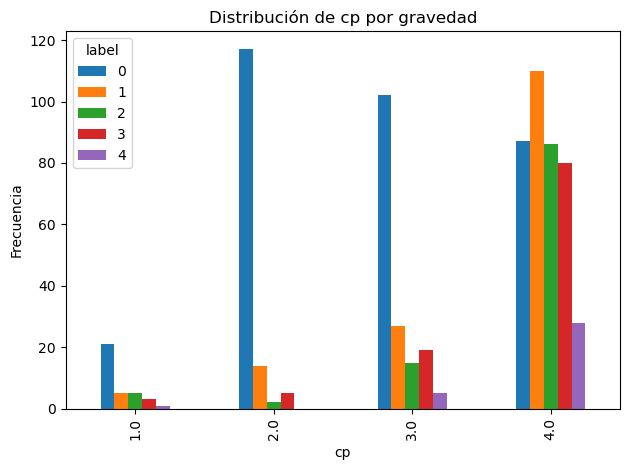

In [89]:
import matplotlib.pyplot as plt

# Contar frecuencia de cp por gravedad (label)
cp_label_counts = train.groupby(['label', 'cp']).size().unstack(fill_value=0)

# Crear gráfico
plt.figure(figsize=(8, 5))
cp_label_counts.T.plot(kind='bar')

plt.xlabel('cp')
plt.ylabel('Frecuencia')
plt.title('Distribución de cp por gravedad')
plt.tight_layout()
plt.show()



### el 2 y el 3 tienen distribuciones un poco similares, podriamos plantear fusionarlas (mediante pruebas).

<Figure size 800x500 with 0 Axes>

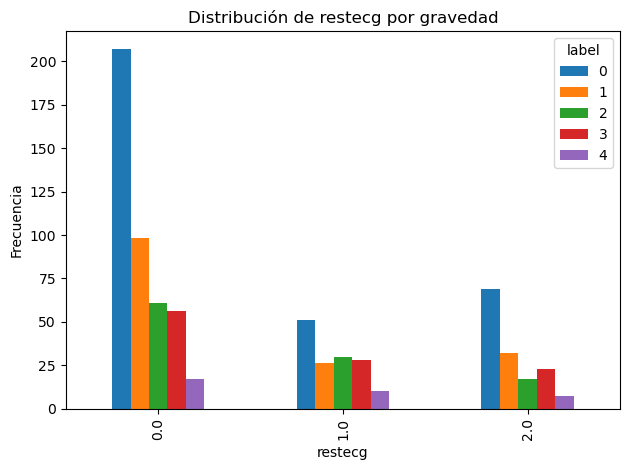

In [90]:
import matplotlib.pyplot as plt

# Contar frecuencia de cp por gravedad (label)
cp_label_counts = train.groupby(['label', 'restecg']).size().unstack(fill_value=0)

# Crear gráfico
plt.figure(figsize=(8, 5))
cp_label_counts.T.plot(kind='bar')

plt.xlabel('restecg')
plt.ylabel('Frecuencia')
plt.title('Distribución de restecg por gravedad')
plt.tight_layout()
plt.show()



### el 1 y el 2 tambien tienen distribuciones similares, lo mismo

<Figure size 800x500 with 0 Axes>

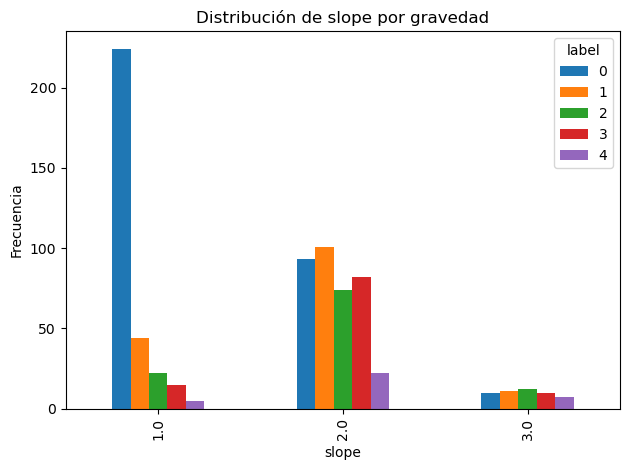

In [91]:
import matplotlib.pyplot as plt

# Contar frecuencia de cp por gravedad (label)
cp_label_counts = train.groupby(['label', 'slope']).size().unstack(fill_value=0)

# Crear gráfico
plt.figure(figsize=(8, 5))
cp_label_counts.T.plot(kind='bar')

plt.xlabel('slope')
plt.ylabel('Frecuencia')
plt.title('Distribución de slope por gravedad')
plt.tight_layout()
plt.show()



### en este caso no hay similitudes

<Figure size 800x500 with 0 Axes>

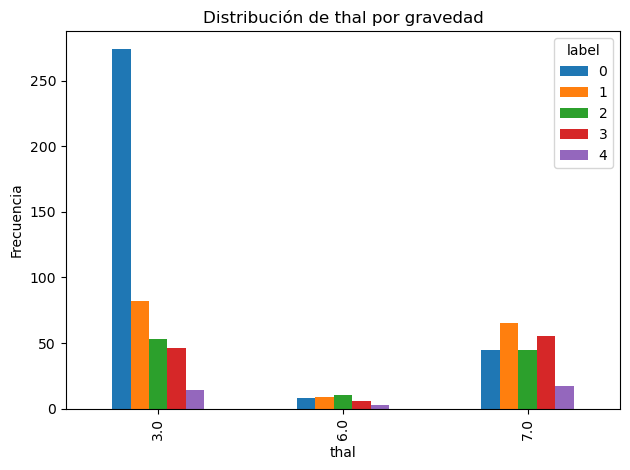

In [92]:
import matplotlib.pyplot as plt

# Contar frecuencia de cp por gravedad (label)
cp_label_counts = train.groupby(['label', 'thal']).size().unstack(fill_value=0)

# Crear gráfico
plt.figure(figsize=(8, 5))
cp_label_counts.T.plot(kind='bar')

plt.xlabel('thal')
plt.ylabel('Frecuencia')
plt.title('Distribución de thal por gravedad')
plt.tight_layout()
plt.show()



### lo mismo

Valores no numéricos eliminados: 49


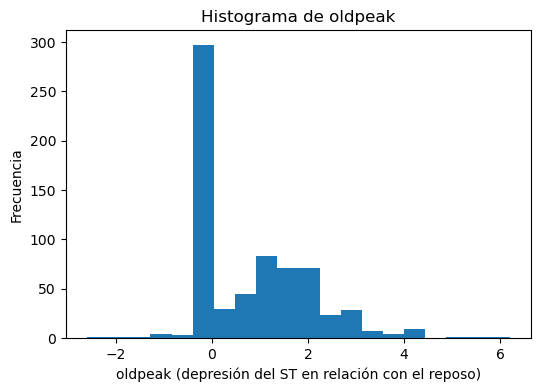

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")

# Convertir trestbps a numérico, forzando errores a NaN
df["oldpeak"] = pd.to_numeric(df["oldpeak"], errors="coerce")

# Eliminar NaN para los gráficos
x = df["oldpeak"].dropna()

print("Valores no numéricos eliminados:", df["oldpeak"].isna().sum())


# ========================
# 1. HISTOGRAMA
# ========================
plt.figure(figsize=(6,4))
plt.hist(df["oldpeak"].dropna(), bins=20)
plt.title("Histograma de oldpeak")
plt.xlabel("oldpeak (depresión del ST en relación con el reposo)")
plt.ylabel("Frecuencia")
plt.show()





Valores no numéricos eliminados: 47
Mediana de trestbps: 130.0


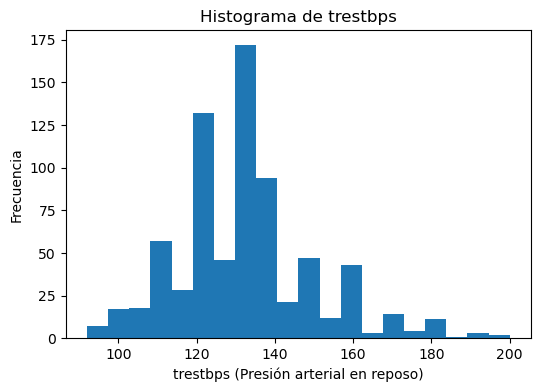

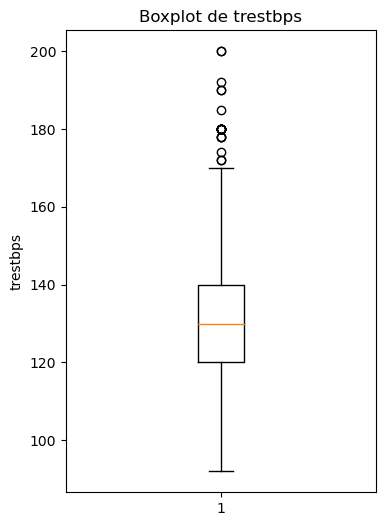

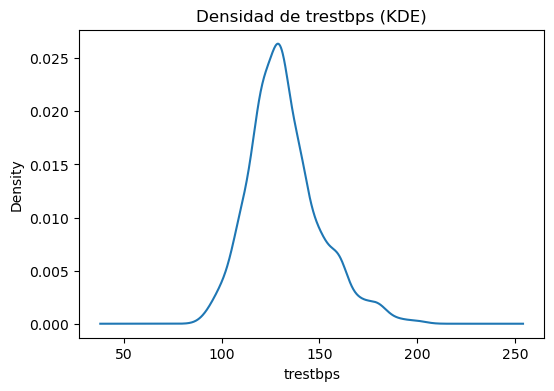

In [ ]:
# Convertir trestbps a numérico, forzando errores a NaN
df["trestbps"] = pd.to_numeric(df["trestbps"], errors="coerce")

# Eliminar NaN para los gráficos
x = df["trestbps"].dropna()

print("Valores no numéricos eliminados:", df["trestbps"].isna().sum())
import numpy as np

# 1. Convertir 0 → NaN (porque no es un valor real)
df["trestbps"] = df["trestbps"].replace(0, np.nan)

# 2. Calcular mediana real
mediana = df["trestbps"].median()
print("Mediana de trestbps:", mediana)

# 3. Reemplazar valores NaN (incluido el 0 original) por la mediana
df["trestbps"].fillna(mediana, inplace=True)

# ========================
# 1. HISTOGRAMA
# ========================
plt.figure(figsize=(6,4))
plt.hist(df["trestbps"].dropna(), bins=20)
plt.title("Histograma de trestbps")
plt.xlabel("trestbps (Presión arterial en reposo)")
plt.ylabel("Frecuencia")
plt.show()

# ========================
# 2. BOXLOT
# ========================
plt.figure(figsize=(4,6))
plt.boxplot(df["trestbps"].dropna(), vert=True)
plt.title("Boxplot de trestbps")
plt.ylabel("trestbps")
plt.show()

# ========================
# 3. DENSIDAD (KDE)
# ========================
plt.figure(figsize=(6,4))
df["trestbps"].dropna().plot(kind="kde")
plt.title("Densidad de trestbps (KDE)")
plt.xlabel("trestbps")
plt.show()

# ========================
# 4. DISPERSIÓN vs gravedad (si existe)
# ========================
if "gravedad" in df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df["trestbps"], df["gravedad"])
    plt.title("trestbps vs Gravedad")
    plt.xlabel("trestbps")
    plt.ylabel("Gravedad")



Valores no numéricos eliminados: 5


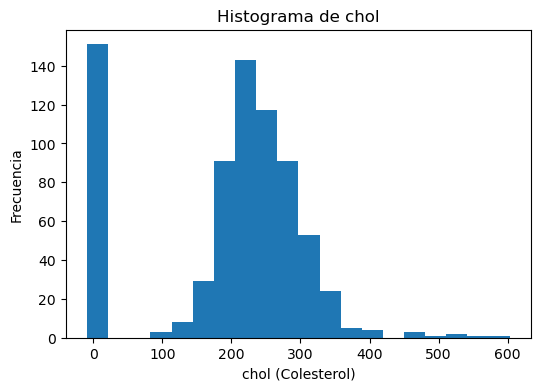

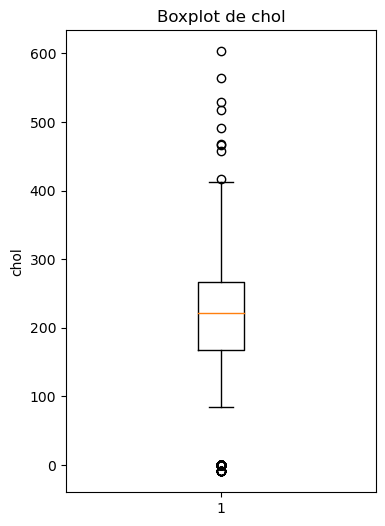

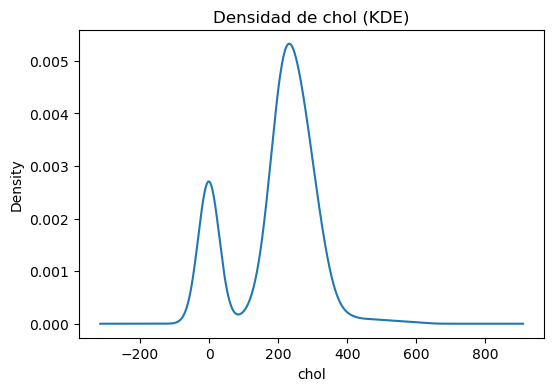

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("train.csv")

# Convertir chol a numérico, forzando errores a NaN
df["chol"] = pd.to_numeric(df["chol"], errors="coerce")

# Eliminar NaN para los gráficos
x = df["chol"].dropna()

print("Valores no numéricos eliminados:", df["chol"].isna().sum())

# ========================
# 1. HISTOGRAMA
# ========================
plt.figure(figsize=(6,4))
plt.hist(x, bins=20)
plt.title("Histograma de chol")
plt.xlabel("chol (Colesterol)")
plt.ylabel("Frecuencia")
plt.show()

# ========================
# 2. BOXPLOT
# ========================
plt.figure(figsize=(4,6))
plt.boxplot(x, vert=True)
plt.title("Boxplot de chol")
plt.ylabel("chol")
plt.show()

# ========================
# 3. DENSIDAD (KDE)
# ========================
plt.figure(figsize=(6,4))
x.plot(kind="kde")
plt.title("Densidad de chol (KDE)")
plt.xlabel("chol")
plt.show()

# ========================
# 4. DISPERSIÓN vs gravedad (si existe)
# ========================
if "gravedad" in df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df["chol"], df["gravedad"])
    plt.title("chol vs Gravedad")
    plt.xlabel("chol")
    plt.ylabel("Gravedad")
    plt.show()


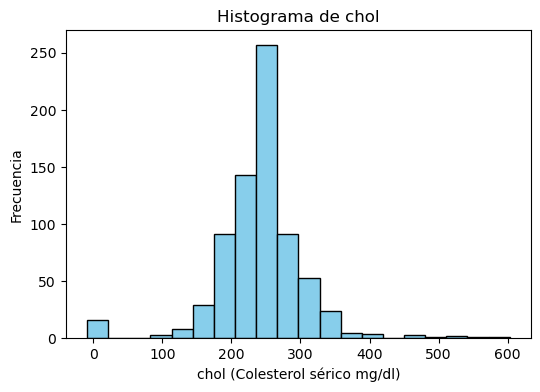

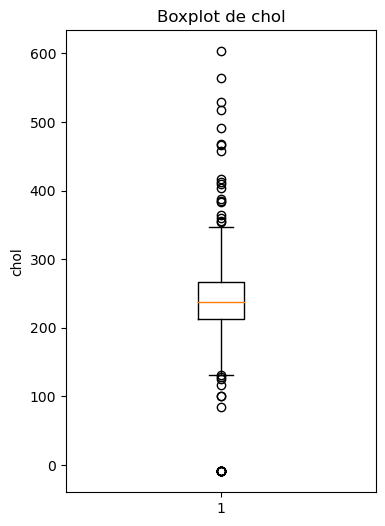

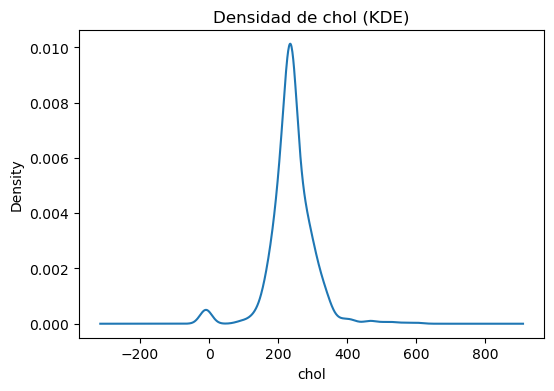

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Convertir todo a string, limpiar espacios, luego a numérico
df["chol"] = pd.to_numeric(df["chol"].astype(str).str.strip(), errors="coerce")

# Reemplazar todos los ceros por NaN
df.loc[df["chol"] == 0, "chol"] = np.nan

# Reemplazar NaN por la mediana
mediana_chol = df["chol"].median()
df["chol"].fillna(mediana_chol, inplace=True)



# ========================
# 1. HISTOGRAMA
# ========================
plt.figure(figsize=(6,4))
plt.hist(df["chol"].dropna(), bins=20, color="skyblue", edgecolor="black")
plt.title("Histograma de chol")
plt.xlabel("chol (Colesterol sérico mg/dl)")
plt.ylabel("Frecuencia")
plt.show()

# ========================
# 2. BOXPLOT
# ========================
plt.figure(figsize=(4,6))
plt.boxplot(df["chol"].dropna(), vert=True)
plt.title("Boxplot de chol")
plt.ylabel("chol")
plt.show()

# ========================
# 3. DENSIDAD (KDE)
# ========================
plt.figure(figsize=(6,4))
df["chol"].dropna().plot(kind="kde")
plt.title("Densidad de chol (KDE)")
plt.xlabel("chol")
plt.show()

# ========================
# 4. DISPERSIÓN vs gravedad (si existe)
# ========================
if "gravedad" in df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df["chol"], df["gravedad"])
    plt.title("chol vs Gravedad")
    plt.xlabel("chol")
    plt.ylabel("Gravedad")
    plt.show()


In [ ]:
print(df.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'label'],
      dtype='object')
